In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

# Load the power dataset
building_data_train = pd.read_csv("data/building_4_weather_1_train.csv", parse_dates=["timestamp"], index_col=["timestamp"])

# Load the weather dataset
weather_data = pd.read_csv("data/weather_1.csv", parse_dates=["timestamp"], index_col=["timestamp"])


In [54]:
# Remove duplicates and fill time series in weather dataset
weather_data = weather_data[~weather_data.index.duplicated()]
weather_data = weather_data.asfreq('H',method='ffill')
# Remove 1 day of nan values in power dataset
building_data_train = building_data_train[ (building_data_train.index < "2017-10-25 00:00:00") | (building_data_train.index > "2017-10-26 23:00:00")]
# Merge the energy and temperature datasets
data = building_data_train.join(weather_data, how='inner')



In [55]:
#weather_data = weather_data.resample("H", axis=0).first()
#weather_data.fillna(method='ffill', inplace=True)

<Axes: xlabel='timestamp'>

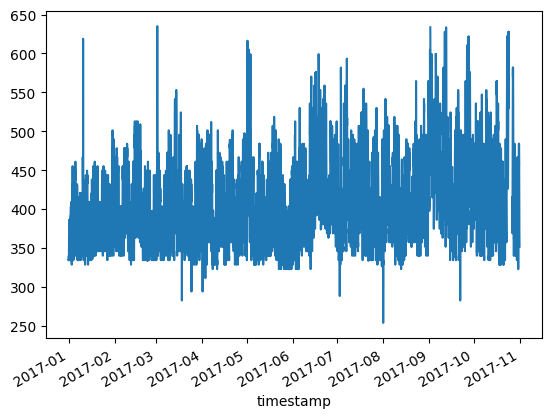

In [56]:
#data['power'].plot()
data['power'].plot()

In [57]:
#outlier detection

def replace_outliers_na(data, column, multiplier=1.5):
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Filter the dataset to remove the outliers
    mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    data.loc[mask, column] = np.nan

    return data

#data = replace_outliers_na(data.copy(), 'power')


In [58]:
print(data['power'].isna().sum())
#data['power'].interpolate(method='spline', inplace=True, order=3, limit = 3) da problemi nelle fasi successive
data['power'].interpolate(method='spline', inplace=True, order=3)
print(data['power'].isna().sum())
#data = data.dropna(subset=['power'])

13
0


In [59]:
#data['power'].plot()


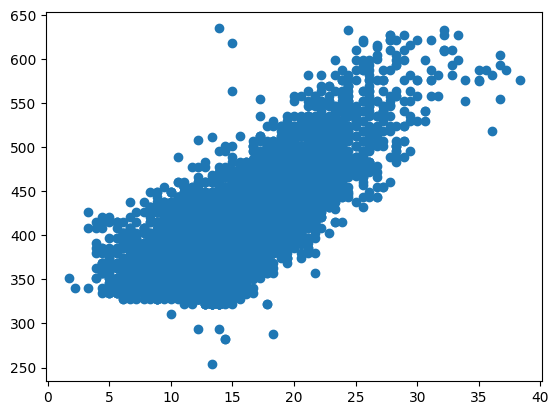

In [60]:

plt.scatter(data['airTemperature'], data['power'])
# from the scatter diagram we can see that the building is not using electrical power for heating in cold days
# When the temperature is high, instead, the building is using electrical power for cooling

In [61]:
# Carpet plot
#data["date"] = data.index.date
#df_pivot = data.pivot_table(index='date', columns='hour', values='power')
#sns.heatmap(df_pivot)


## Load profiles characterization
##### Perform on the training dataset a load profile characterization process based on unsupervised clustering algorithms according to the following steps:
- Dataset manipulation: the training dataset should be organized into a MxN matrix to perform clustering according to one of the methods introduced during the course.
- Identification of the “best” clustering solution: the “best” number of clusters should be identified according to both evaluation metrics (i.e. silhouette index and davies bouldin index) introduced during the course and personal considerations with respect to the results obtained.
- Data visualization and comment: visualizations describing the solution obtained should be produced with a critical comment of the results

In [62]:
from sklearn.cluster import KMeans


# Feature engineering
# extract the date only from the timestamp only, not the time
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['date'] = data.index.date

df_matrix = data.pivot(index='date', columns='hour', values='power')



<Axes: xlabel='hour', ylabel='date'>

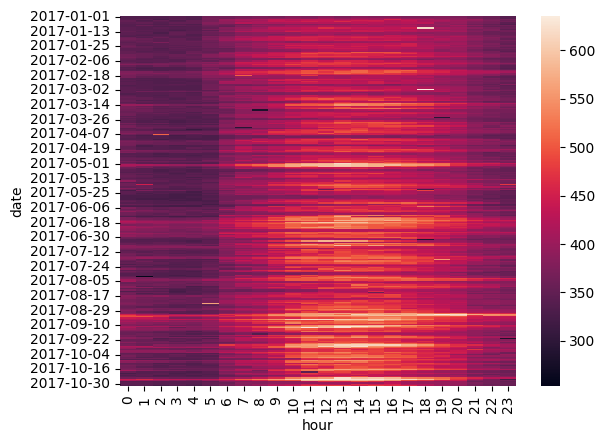

In [63]:
sns.heatmap(df_matrix)

In [64]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

K_range = [2, 3, 4, 5, 6, 7, 8]
db_list = []
sh_list = []

# write your code here
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
    labels = kmeans.labels_
    sh_list.append(silhouette_score(df_matrix, kmeans.labels_))
    db_list.append(davies_bouldin_score(df_matrix, kmeans.labels_))
    print(np.unique(labels, return_counts=True))
print(f"The best number of clusters according to Silhouette is {K_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {K_range[np.argmin(db_list)]}")

c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.p

(array([0, 1]), array([ 78, 224], dtype=int64))
(array([0, 1, 2]), array([141, 116,  45], dtype=int64))
(array([0, 1, 2, 3]), array([100,  19,  54, 129], dtype=int64))
(array([0, 1, 2, 3, 4]), array([100,  55,  40,  16,  91], dtype=int64))
(array([0, 1, 2, 3, 4, 5]), array([97, 55, 91,  2, 17, 40], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([93, 24, 55, 15, 30, 83,  2], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([22, 86, 39, 54,  2, 59, 25, 15], dtype=int64))
The best number of clusters according to Silhouette is 2
The best number of clusters according to DB Index is 2


c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [75]:
# Perform clustering
K = 4
kmeans = KMeans(n_clusters=K, random_state=0).fit(df_matrix)
labels = kmeans.labels_
print(labels)
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts


[0 0 0 3 3 0 0 0 0 3 0 0 3 0 0 0 3 3 3 3 0 0 0 3 3 0 0 0 0 3 3 3 3 3 0 0 3
 3 3 3 3 0 0 3 2 2 2 3 0 0 0 3 0 0 0 0 0 0 0 3 3 0 0 0 0 3 3 3 3 0 0 2 2 3
 3 2 0 0 3 3 0 0 0 0 0 0 3 3 3 3 3 0 3 3 3 3 3 0 0 0 3 3 3 3 0 0 0 3 3 3 3
 0 0 0 0 0 3 3 3 3 1 1 1 3 3 0 0 0 3 0 3 0 0 0 3 3 3 2 2 3 0 3 3 0 0 0 0 0
 0 0 3 3 3 0 0 3 3 3 3 3 0 0 2 3 2 2 1 2 1 1 2 2 2 2 3 0 2 2 3 2 2 0 0 2 0
 2 2 2 3 0 3 3 3 3 3 3 2 2 3 2 2 2 3 0 3 3 3 2 3 0 0 3 3 2 2 2 0 0 3 3 3 3
 3 0 0 0 3 3 3 3 0 0 3 3 3 3 3 3 3 2 3 3 1 1 1 1 2 1 2 2 2 3 1 1 1 2 2 2 0
 0 3 2 2 3 3 3 3 2 1 1 2 3 3 3 2 2 3 2 2 3 3 2 2 3 2 3 3 3 2 2 0 3 3 0 3 1
 1 1 0 0 0 3]


c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3]), array([100,  19,  54, 129], dtype=int64))

In [76]:
data['cluster'] = np.repeat(labels, 24)

In [77]:
# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = data.groupby(['cluster', 'hour'])['power'].mean().reset_index()

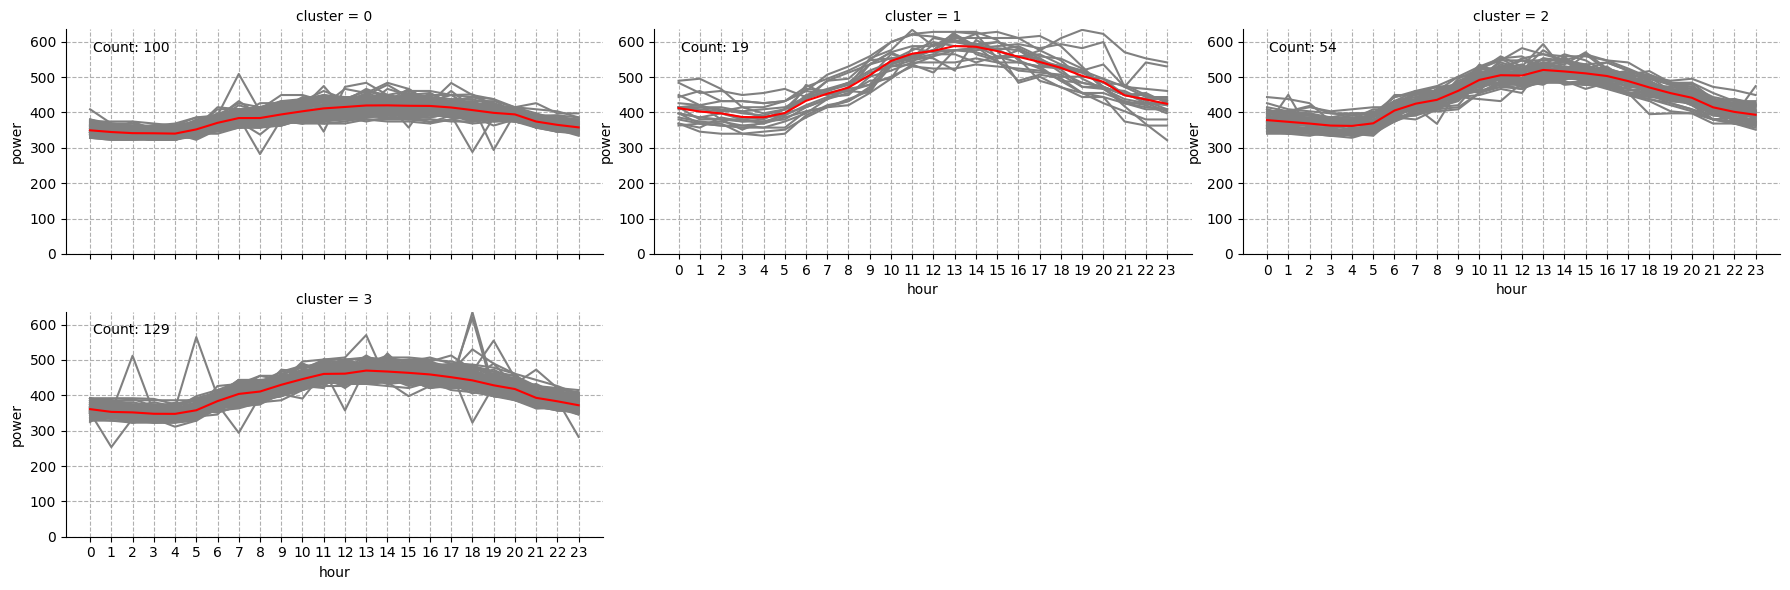

In [78]:
# generating load profiles
g = sns.FacetGrid(data=data, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=data['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1



plt.show()

c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itlofen\CourseAI\Team4\data-science-and-ai-for-industrial-systems\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


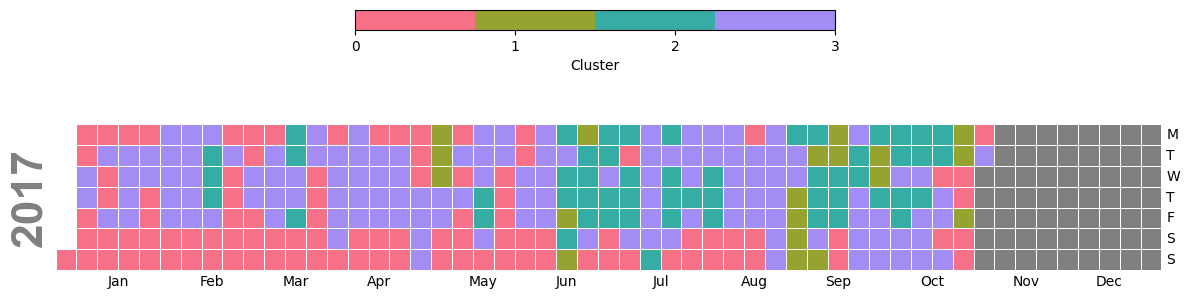

In [79]:
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))

# define colors accordin to palette
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(np.sort(cal_data['cluster'].unique()))
cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

plt.show()